<a href="https://colab.research.google.com/github/dnhshl/hyperparameter_doe/blob/main/simpleRobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simpleRobot
Neuronales Netz zur Berechnung der inversen Kinematik eines (sehr einfachen) Roboters mit zwei Freiheitsgraden.





## Lade notwendige Libraries


In [12]:
!pip install keras_sequential_ascii

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt

from keras_sequential_ascii import keras2ascii



  Created wheel for keras-sequential-ascii: filename=keras_sequential_ascii-0.1.1-cp37-none-any.whl size=3062 sha256=6e78035cbfebe6a05c1c901923e94f419c1770e53670f9168dde4516aee96b00
  Stored in directory: /root/.cache/pip/wheels/f5/8d/81/912666dff82a923ce423a7e797cd75f54271c7031512cdb282
Successfully built keras-sequential-ascii


# Daten

Generiere Trainingsdaten. Das ist hier sehr einfach, da bei bekannten Winkeln `phi1` und `phi2` die `x` und `y` Position berechnet werden kann. 

Der Einfachheit halber (um auszuschließen, dass gleiche Positionen mit unterschiedlichen Winkelstellungen angefahren werden können) wird `phi1` auf 0 .. 90 Grad und `phi2` auf -90 .. 0 Grad eingeschränkt.

## Vorab: Vektoren und Matrizen in numpy

In [10]:
a = np.array([1,2,3]) # Zeilenvektor a
b = np.array([4,5,6]) # Zeilenvektor b

M = np.vstack((a, b)) # Zusammenfassen als 2x3 Matrix

M = M.T # Transponieren -> 3x2 Matrix

print(a, b)
print(M)

sum_a_b = M.sum(axis=1) # Summe der Spaltenvektoren
print(sum_a_b)

[1 2 3] [4 5 6]
[[1 4]
 [2 5]
 [3 6]]
[5 7 9]


## OK, jetzt also die Trainingsdaten

In [8]:
l1 = 1  # Länge des ersten Roboterarms
l2 = 1  # Länge des zweiten Roboterarms


def gen_data(size):

  # phi1 im Bereich von 0 .. 90 Grad 
  phi1 = np.random.random_sample(size) * np.pi/2 

  # phi2 im Bereich von 0 .. -90 Grad 
  phi2 = -np.random.random_sample(size) * np.pi/2

  # Kombiniere Vektoren als Matrix
  dout = np.vstack((phi1, phi2)).T

  # Berechne x und y
  din = np.array([l1 * np.cos(dout[:,0]) + l2 * np.cos(dout.sum(axis=1)), 
                  l1 * np.sin(dout[:,0]) + l2 * np.sin(dout.sum(axis=1))]).T 

  return (din, dout)

traindatasize = 200000 # Wie viele Traingsdaten sollen generiert werden?

(din, dout) = gen_data(traindatasize)

print(dout[:4])
print(din[:4])




[[ 0.33927327 -0.4553461 ]
 [ 0.8808725  -1.40389079]
 [ 0.04154506 -0.12179294]
 [ 0.45735775 -1.10074064]]
[[ 1.93626788  0.21698951]
 [ 1.50279393  0.2717973 ]
 [ 1.99591899 -0.03862868]
 [ 1.69729332 -0.15832645]]


## Welcher Bereich `(x, y)` kann vom Roboter erreicht werden?

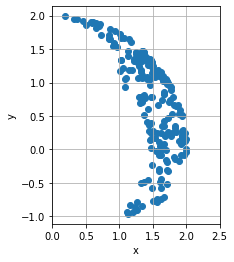

In [41]:

def plot_range():
  plt.scatter(din[:200,0], din[:200,1])
  plt.xlabel('x')
  plt.ylabel('y')
  plt.xlim(0,2.5)
  plt.grid(True)
  plt.gca().set_aspect("equal")


plot_range()

# NN

Zwei Fully Connected Layer, der erste Layer mit Aktivierungsfunktion.

Als Fehlerfunktion wird der quadratische Fehler genutzt. Sie können auch [andere Loss Functions](https://keras.io/api/losses/) ausprobieren.

Testen Sie auch verschiedene [Optimizer](https://keras.io/api/optimizers/) .

## Hyperparameter

In [24]:
# Netzwerkparameter

layer1size = 100
layer2size = 100

# Trainingsparameter

myoptimizer = optimizers.Adam
learning_rate = 0.01
batch_size = 32
epochs = 10

## Konstruiere NN

In [25]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(layer1size, input_shape=[2,], activation='tanh'),
      layers.Dense(layer2size, activation='tanh'),
      layers.Dense(2)     ## output
  ])

  model.compile(loss='mean_squared_error',
                optimizer=myoptimizer(learning_rate=0.01))
  return model

In [26]:
mymodel = build_and_compile_model()
mymodel.summary()

print()
print('________________________')
print('NN Struktur in Ascii Art')
print('________________________')
print()

keras2ascii(mymodel)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 202       
Total params: 10,602
Trainable params: 10,602
Non-trainable params: 0
_________________________________________________________________

________________________
NN Struktur in Ascii Art
________________________

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           2
               Dense   XXXXX -------------------       300     2.8%
                tanh   #####         100
               Dense   XXXXX -------------------     10100    95.3%
           

## Trainiere Modell

Nutze 20% der Testdaten als Validierungsdatensatz

In [36]:


history = mymodel.fit(din, dout,
          batch_size=batch_size, epochs=epochs,
          validation_split = 0.2)

Epoch 1/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 2/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 3/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0019 - val_loss: 7.9265e-04
Epoch 4/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 5/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 6/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0015 - val_loss: 5.7695e-04
Epoch 7/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0018 - val_loss: 3.9830e-04
Epoch 9/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 10/10
5000/5000 [==============================] - 7s 1ms/step -

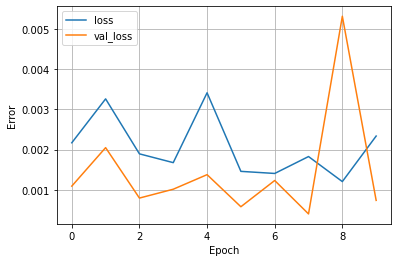

In [37]:


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

## Teste trainiertes Modell

In [38]:
testdatasize = 100

(testdata_in, testdata_out) = gen_data(testdatasize)

predictions = mymodel.predict(testdata_in)


for i in range(10):
  print(predictions[i], testdata_out[i])

[ 0.27896965 -0.13811213] [ 0.20895911 -0.02486708]
[ 0.4038282  -0.51992077] [ 0.39822401 -0.5319136 ]
[ 0.7151596 -1.0808456] [ 0.71797844 -1.11093271]
[ 0.04173994 -0.84287757] [ 0.06078311 -0.8890658 ]
[ 1.4717311 -0.9650646] [ 1.47883896 -1.01088071]
[ 1.0363598  -0.19586217] [ 1.04267234 -0.22581177]
[ 0.74792635 -0.9501055 ] [ 0.75068928 -0.98159512]
[ 1.0011431  -0.47369337] [ 1.00589682 -0.48147511]
[ 0.1172999 -0.4068613] [ 0.11584539 -0.4325089 ]
[ 1.3237551  -0.25412244] [ 1.32519237 -0.27339063]


## Teste verschiedene Trajektorien

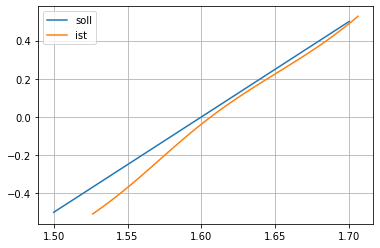

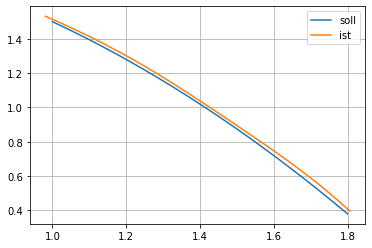

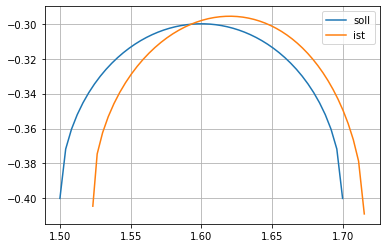

In [40]:
# Gerade
xtest1 = np.linspace(1.5,1.7)
ytest1 = 1/0.2*(xtest-1.5) -0.5

# Parabel
xtest2 = np.linspace(1, 1.8)
ytest2 = -0.5*xtest2*xtest2 +2

# Kreisbogen
xtest3 = np.linspace(-0.1, 0.1)
ytest3 = np.sqrt(0.1*0.1 - xtest3*xtest3)
xtest3 = xtest3 + 1.6
ytest3 = ytest3 - 0.4


def plot_trajectory(x, y):
  plt.figure()
  plt.plot(x,y, label='soll')
  phipred = mymodel.predict(np.vstack((x, y)).T)

  # Berechne x und y
  xpred = l1 * np.cos(phipred[:,0]) + l2 * np.cos(phipred.sum(axis=1))
  ypred = l1 * np.sin(phipred[:,0]) + l2 * np.sin(phipred.sum(axis=1))

  plt.plot(xpred, ypred, label='ist')
  plt.grid(True)
  plt.legend()


plot_trajectory(xtest1, ytest1)

plot_trajectory(xtest2, ytest2)

plot_trajectory(xtest3, ytest3)

